# Geometrical Methods in Machine Learning
## Seminar 5: Topological Data Analysis

In [12]:
from __future__ import print_function

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

import simplicial # a modified version of simplicial package is included with the repo
import simplicial.drawing

from ripser import lower_star_img # pip install ripser
from ripser import Rips
vr = Rips()

import persim # pip install persim
import diagram2vec # pip install diagram2vec

from scipy.ndimage import gaussian_filter

from sklearn.datasets import make_circles
from sklearn.manifold import MDS

from sklearn.decomposition import PCA

import pickle

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


## 1. Simplicial complexes and homology

**Exercise**: create a simplicial complex consisting of 7 vertices and 6 edges

In [26]:
# create simplicial complex
cmplx = simplicial.SimplicialComplex()

In [27]:
# add 0-simplices (vertices)
v1 = cmplx.addSimplex(id="v1")
v2 = cmplx.addSimplex(id="v2")
v3 = cmplx.addSimplex(id="v3")
v4 = cmplx.addSimplex(id="v4")
v5 = cmplx.addSimplex(id="v5")
v6 = cmplx.addSimplex(id="v6")
v7 = cmplx.addSimplex(id="v7")

In [28]:
# add 1-simplices (edges)
cmplx.addSimplex(['v2', 'v3'], id="e1")
cmplx.addSimplex(['v4', 'v5'], id="e2")
cmplx.addSimplex(['v4', 'v6'], id="e3")
cmplx.addSimplex(['v5', 'v6'], id="e4")
cmplx.addSimplex(['v5', 'v7'], id="e5")
cmplx.addSimplex(['v6', 'v7'], id="e6")

'e6'

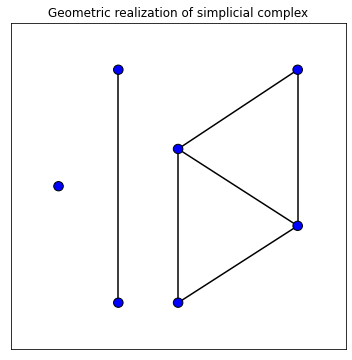

In [29]:
# set coordinates for vertices
em = simplicial.Embedding(cmplx)
em.positionSimplex(v1, (0.0, 0.5))

em.positionSimplex(v2, (0.25, 1.0))
em.positionSimplex(v3, (0.25, 0.0))

em.positionSimplex(v4, (1.0, 1.0))
em.positionSimplex(v5, (0.5, 0.66))
em.positionSimplex(v6, (1.0, 0.33))
em.positionSimplex(v7, (0.5, 0.0))

# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
simplicial.drawing.draw_complex(cmplx, em)

### Betti numbers

_K-th Betti number_ of topological space is the rank of its' associated _k-th homological group_ and describes the number of holes of dimension $k+1$.

- 0-dimensional holes are connected components
- 1-dimensional holes are loops
- 2-dimensional holes are voids

**Exercise**

Evaluate the dimensionality and non-vanishing Betti numbers of a simplicial complex

In [30]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [31]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 1
Betti-0: 3
Betti-1: 2


### Modifying the topology of the simplicial complex

**Exercise**

Modify the topology of the simplicial complex by "filling" one of its' 2-dimensional holes by a 2-simplex which is a triangle.

In [32]:
# add 2-simplex (triangle)
cmplx.addSimplex(['e2', 'e3', 'e4'], id="t1")

't1'

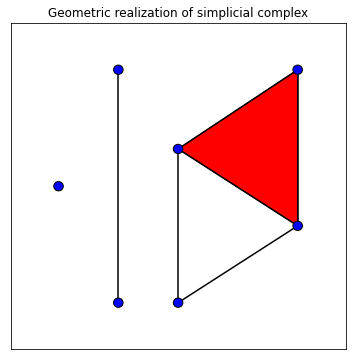

In [33]:
# draw simplicial complex
fig = plt.figure(figsize=(6,6))
plt.title("Geometric realization of simplicial complex")
simplicial.drawing.draw_complex(cmplx, em)

In [34]:
# evaluate complex dimension
dim = cmplx.maxOrder()

# evaluate Betti numbers
betti = cmplx.bettiNumbers()

In [35]:
print("Dimension of complex: {}".format(dim))
for key in betti:
    if key <= dim:
        print("Betti-{}: {}".format(str(key), betti[key]))

Dimension of complex: 2
Betti-0: 3
Betti-1: 1
Betti-2: 0


## 2. Persistent homology, persistent diagrams, Wasserstein distance and stability

In [36]:
# original data
X, y = make_circles(n_samples=200, noise=0.1)
X = X[y==0]

Topology studies data invariant to continous transformations, so topological invariants like (persistent) homology will not change under such class of transformations.

**Exercise**

Apply rotation and dilation transformations to copy of original data.

In [37]:
theta = np.radians(30)
c, s = np.cos(theta), np.sin(theta)
R = np.array(((c,-s), (s, c)))
print(R)

[[ 0.8660254 -0.5      ]
 [ 0.5        0.8660254]]


In [38]:
# transformed data
X_transformed = np.copy(X)
X_transformed[:,0] = X[:,0] * 0.75
X_transformed = np.dot(X_transformed, R)

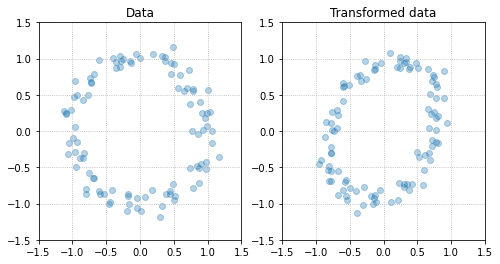

In [39]:
fig = plt.figure(figsize=(8,4))

plt.subplot(121)
plt.title("Data")
plt.grid(linestyle="dotted")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X[:,0], X[:,1], alpha=0.33)

plt.subplot(122)
plt.title("Transformed data")
plt.grid(linestyle="dotted")
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.scatter(X_transformed[:,0], X_transformed[:,1], alpha=0.33)

plt.show()

**Exercise**

Compute persistence diagrams of a filtration of Vietoris-Rips complex built on point cloud data

In [43]:
diagram = vr.fit_transform(X)
diagram_transformed = vr.fit_transform(X_transformed)

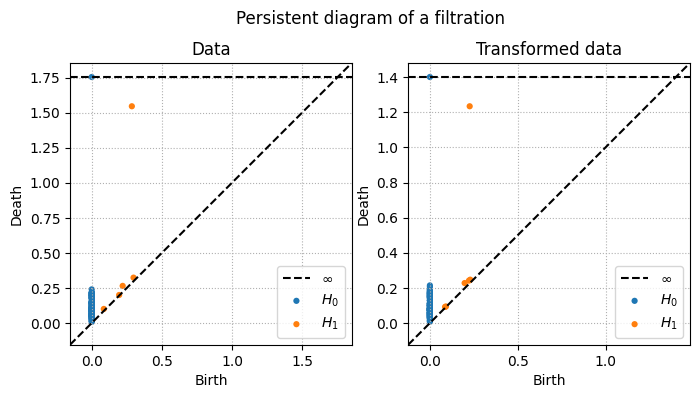

In [44]:
fig = plt.figure(figsize=(8,4))
plt.suptitle("Persistent diagram of a filtration")

plt.grid(linestyle="dotted")

plt.subplot(121)
plt.title("Data")
plt.grid(linestyle="dotted")
vr.plot(diagram)

plt.subplot(122)
plt.title("Transformed data")
plt.grid(linestyle="dotted")
vr.plot(diagram_transformed)

plt.show()

One can define the geometry on the space of persistent diagrams, defining a metric on it. Optimal transport approach is used to compare persistent diagrams which are multisets of intervals of arbitrary cardinality.  

The variants of optimal transport distances are Wasserstein\-2 distance, and its approximations like sliced Wasserstein distance and Bottleneck distance, which is Wasserstein-$\infty$ distance.

**Exercise**

Compute Bottleneck `persim.bottleneck` and sliced Wasserstein distances `persim.sliced_wasserstein` between perisistent diagrams of original and transformed data.

In [45]:
diagram

[array([[0.        , 0.00774905],
        [0.        , 0.01445472],
        [0.        , 0.01459052],
        [0.        , 0.02374161],
        [0.        , 0.02786472],
        [0.        , 0.02927777],
        [0.        , 0.03196048],
        [0.        , 0.03621593],
        [0.        , 0.03852823],
        [0.        , 0.04176205],
        [0.        , 0.042029  ],
        [0.        , 0.04700834],
        [0.        , 0.0470993 ],
        [0.        , 0.05156034],
        [0.        , 0.05182818],
        [0.        , 0.05200157],
        [0.        , 0.0529463 ],
        [0.        , 0.05401386],
        [0.        , 0.05426918],
        [0.        , 0.056535  ],
        [0.        , 0.05831239],
        [0.        , 0.05894299],
        [0.        , 0.06076023],
        [0.        , 0.06293862],
        [0.        , 0.06334252],
        [0.        , 0.06487517],
        [0.        , 0.06489216],
        [0.        , 0.06550618],
        [0.        , 0.06858341],
        [0.   

In [46]:
diagram[1].shape

(5, 2)

In [47]:
diagram_transformed[1].shape

(6, 2)

In [48]:
# your code here
persim.bottleneck(diagram[1], diagram_transformed[1])

0.3114614486694336

In [49]:
# your code here
persim.sliced_wasserstein(diagram[1], diagram_transformed[1])

0.3610148218634435

Bottlneck distance used a single matching between most discriminative pair of points.

**Exercise**

Visualize Bottleneck matching.

In [50]:
# compute Bottleneck distance matching
d, (matching, D) = persim.bottleneck(diagram[1], diagram_transformed[1], matching=True)

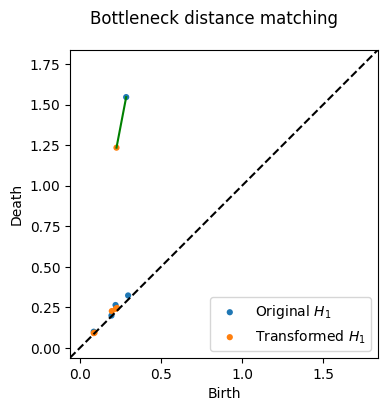

In [51]:
# plot Bottleneck distance matchign
fig = plt.figure(figsize=(8,4))
plt.suptitle("Bottleneck distance matching")
persim.bottleneck_matching(diagram[1], diagram_transformed[1], matching, D, labels=['Original $H_1$', 'Transformed $H_1$'])


For Bottleneck distance stability to small perturbations is theoretically proved.

**Exercise**

Plot Bottleneck distance with respect to different level of Gaussian noise applied to original data.

In [54]:
# original data
X_orig, y = make_circles(n_samples=200, noise=0.0)
X_orig = X_orig[y==0]
diagram_orig = vr.fit_transform(X_orig)

# your code here
dists = []

for noise in np.arange(0, 0.3, 0.02):
    X_noise, y = make_circles(n_samples=200, noise=noise)
    X_noise = X_noise[y==0]
    diagram_noise = vr.fit_transform(X_noise)
    
    dists.append(persim.bottleneck(diagram_orig[1], diagram_noise[1]))

In [55]:
dists

[0.0,
 0.0815538540482521,
 0.14792826026678085,
 0.16733115166425705,
 0.2672255039215088,
 0.22071599960327148,
 0.2929420992732048,
 0.31342613697052,
 0.39485108852386475,
 0.5272408723831177,
 0.4872180223464966,
 0.6878619194030762,
 0.4951251745223999,
 0.5160427093505859,
 0.8448958955705166]

## 3. Persistent homology of graphs

Pipeline is as follows:

1. compute persistent diagrams via Ripser 
2. compute vectorization of diagrams, so-called persistent images and Betti curves
3. apply classifier on vectorization

In [56]:
# load data
X_graphs = pickle.load(open("./data/metric_graphs/X.pkl", "rb"))
y = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb"))
y_dnod = pickle.load(open("./data/metric_graphs/y_d_nod.pkl", "rb"))

y_col = ["a"] * len(y)
y_col = np.array(y_col)

y_col[y==0] = "blue"
y_col[y==2] = "green"
y_col[y==1] = "red"
y_col[y==3] = "yellow"

### Compute persistent diagrams

In [57]:
# add h_1 diagrams only
maxdim = 1
h = 1

rips = Rips(maxdim=maxdim)

diagrams = []
for x in X_graphs:
    diagrams.append(rips.fit_transform(x, distance_matrix=True)[h])

len(diagrams)

Rips(maxdim=1, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


100

### Clusterization

In [58]:
%%time
n = len(X_graphs)
distances = np.zeros((n, n))

for i in range(0, n):
    for j in range(i+1, n):
        distances[i,j] = persim.sliced_wasserstein(diagrams[i], diagrams[j])
        
distances_symmetrize = distances + distances.T

CPU times: user 3min 51s, sys: 2.42 s, total: 3min 53s
Wall time: 4min 1s


In [59]:
distances_symmetrize = distances + distances.T

In [60]:
mds = MDS(n_components=10, max_iter=3000, eps=1e-9, dissimilarity="precomputed", random_state=1, n_jobs=-1)
X_metric = mds.fit(distances_symmetrize).embedding_

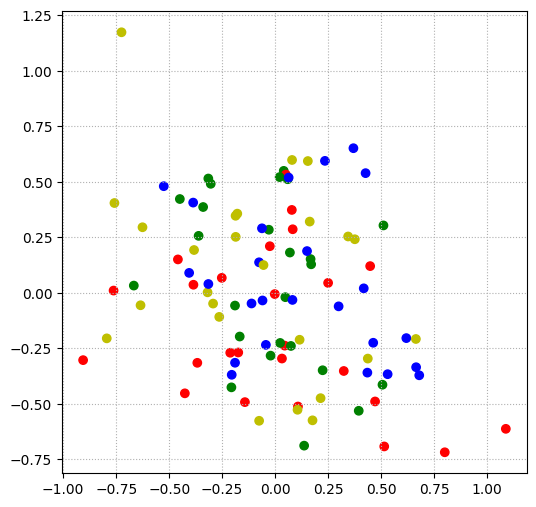

In [61]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_metric[:, 0], X_metric[:, 1], c=y_col)
plt.show()

As we see persistence homology do not provide meaninful clusterization for this dataset, further we see that the classification performance is very low too. But that is of course is not valid for graphs in common.

### Vectorization

Persistent diagram is a multiset of intervals of arbitrary length which is can not be handled by methods of machine learning.

#### Persistent images

One possible to solutions besides providing a metric on the space of persistent diagrams is vectorization of diagrams to a vector of fixed length.

In [63]:
pi = persim.PersImage(spread=0.025, pixels=[32, 32])
pimages = np.array(pi.transform(diagrams))

pimages.shape

PersImage(pixels=[32, 32], spread=0.025, specs=None, kernel_type="gaussian", weighting_type="linear")


(100, 32, 32)

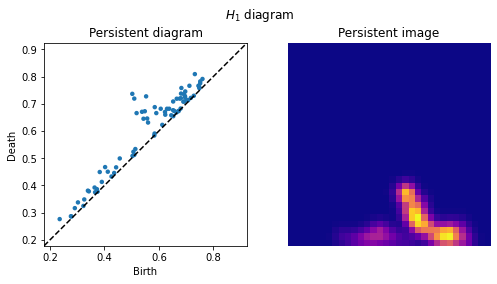

In [64]:
plt.figure(figsize=(8,4))

plt.suptitle("$H_" + str(h) + "$ diagram")

plt.subplot(121)
plt.title("Persistent diagram")
rips.plot(diagrams[0], legend=False)

plt.subplot(122)
plt.title("Persistent image")
pi.show(pimages[0])

plt.show()

### Classification

In [ ]:
X_all = pimages.reshape((pimages.shape[0], -1))
y_all = pickle.load(open("./data/metric_graphs/y_all.pkl", "rb")).astype(int)

X_control = X_all[y_all==0]
X_depression = X_all[y_all==1]
X = np.concatenate((X_control, X_depression), axis=0)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

In [ ]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = LogisticRegression(penalty='l2', C=10.0, solver='liblinear', random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

#### Betti curves

In [97]:
X_betti_curve = diagram2vec.persistence_curve(diagrams, m=20)
X_betti_curve

array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]])

In [98]:
X_control = X_betti_curve[0][y_all==0]
X_depression = X_betti_curve[0][y_all==1]
X = np.concatenate((X_control, X_depression), axis=0)
y = np.concatenate((np.zeros(25), np.ones(25)), axis=0)

In [99]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X, y):
    X_train, y_train = X[train_index], y[train_index]
    X_test, y_test = X[test_index], y[test_index]

    model = RandomForestClassifier(random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.5480 ± 0.1360


## 4. Persistent homology of digital images

Persistence Diagrams with Linear Machine Learning Models (Obayashi, Hiraoka), 2017  
https://arxiv.org/abs/1706.10082

In [2]:
W = 300
sigma1 = 4
sigma2 = 2
t = 0.01

def generate(N, S, W=300, sigma1=4, sigma2=2, t=0.01, bins=64):

    z = np.zeros((N, S, 2))
    for n in range(N):
        z[n, 0] = np.random.uniform(0, W, size=(2))
        for s in range(S-1):
            d_1 = np.random.normal(0, sigma1)
            d_2 = np.random.normal(0, sigma1)
            z[n, s+1, 0] = (z[n, s, 0] + d_1) % W
            z[n, s+1, 1] = (z[n, s, 1] + d_2) % W

    z_r = z.reshape(N*S, 2)
    H, _, _ = np.histogram2d(z_r[:,0], z_r[:,1], bins=bins)
    
    G = gaussian_filter(H, sigma2)
    G[G < t] = 0
    
    return G

### Image generation

Generate 100 images accoring to model A and model B

In [3]:
images = np.zeros((100,64,64))

# class A
N = 100
S = 30

for n in range(50):
    images[n] = generate(N, S)
    
# class B
N = 250
S = 10

for n in range(50):
    images[n+50] = generate(N, S)

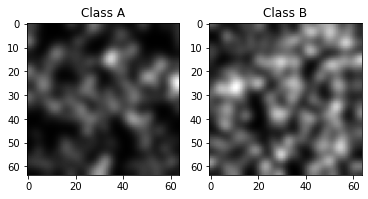

In [4]:
fig = plt.figure()
plt.gray()

ax1 = fig.add_subplot(121)
plt.title("Class A")

ax2 = fig.add_subplot(122)
plt.title("Class B")

ax1.imshow(images[int(np.random.uniform(0, 50))])
ax2.imshow(images[int(np.random.uniform(51, 100))])

plt.show()

### Compute persistent diagrams

In [5]:
diags = []

for i in range(images.shape[0]):
    diags.append(lower_star_img(images[i])[:-1])

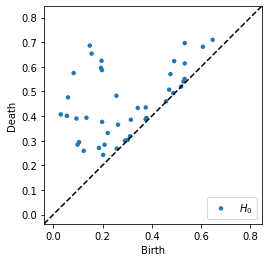

In [6]:
plt.figure(figsize=(4,4))
persim.plot_diagrams(diags[52])

### Vectorization

In [7]:
pi = persim.PersImage(spread=0.025, pixels=[32, 32], verbose=False)
pers_images = np.array(pi.transform(diags))

betti_curves = diagram2vec.persistence_curve(diags, m=25)

pers_images.shape, betti_curves.shape

((100, 32, 32), (1, 100, 25))

### Classification

#### Persistent images

In [8]:
X_images = images.reshape((pers_images.shape[0], -1))
y = np.concatenate((np.zeros(50), np.ones(50)), axis=0)

y_col = ["b"] * len(y)
y_col = np.array(y_col)

y_col[y==1] = "r"

In [9]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X_images, y):
    X_train, y_train = X_images[train_index], y[train_index]
    X_test, y_test = X_images[test_index], y[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.9160 ± 0.0612


#### Betti curves

In [10]:
X_betti_curves = betti_curves[0]
y = np.concatenate((np.zeros(50), np.ones(50)), axis=0)

y_col = ["b"] * len(y)
y_col = np.array(y_col)

y_col[y==1] = "r"

In [11]:
skf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

accuracies = []

for train_index, test_index in skf.split(X_betti_curves, y):
    X_train, y_train = X_betti_curves[train_index], y[train_index]
    X_test, y_test = X_betti_curves[test_index], y[test_index]

    model = RandomForestClassifier(n_estimators=100, random_state=42)

    model.fit(X_train, y_train)
    accuracies.append(model.score(X_test, y_test))

print("Accuracy: {:.4f} ± {:.4f}".format(np.mean(accuracies), np.std(accuracies)))

Accuracy: 0.9400 ± 0.0548


### Clusterization

**Exercise**

Compute the two-dimensional embeddings using linear and nonlinear techniques learned during the course, given persistent images, Betti curves and pairwise distances between data points.

In [13]:
X_emb = PCA(n_components=2).fit_transform(X_betti_curves)

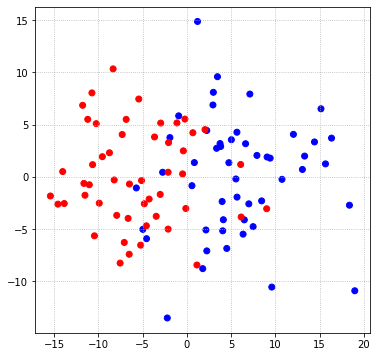

In [14]:
plt.figure(figsize=(6,6))
plt.grid(linestyle="dotted")

plt.scatter(X_emb[:, 0], X_emb[:, 1], c=y_col)
plt.show()